# Escrow Inclusion Sweep Run Experiment

*Danilo Lessa Bernardineli, Shawn Anderson November 2023*

In this notebook, we run an escrow inclusion sweep run that compares two parameter sets. 

## Part 1. Dependences & Set-up

In [19]:
import sys
sys.path.append('../')

import os

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import hvplot.pandas
import holoviews as hv

pio.renderers.default = "png" # For GitHub rendering

## Part 2. Load Simulation Data

In [20]:
sim_df = pd.read_pickle(
    "../data/simulations/fund_inclusion-2024-01-02_10-17-17.pkl.gz"
)

In [21]:
sim_df.head()

,days_passed,blocks_passed,circulating_supply,user_supply,issued_supply,total_supply,sum_of_stocks,block_utilization,dsf_relative_disbursal_per_day,reward_issuance_balance,...,run,timestep,delta_days,delta_blocks,average_compute_weight_per_budle,label,environmental_label,timestep_in_days,block_time_in_seconds,max_credit_supply
0,0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,1.320000e+09,...,1,0,NaN,NaN,NaN,default-issuance-function,standard,1,6,3000000000
14,1,14400.0,13.698630,13.698630,1.680000e+09,1.680000e+09,3.000000e+09,0.000002,0.0,1.320000e+09,...,1,1,1.0,14400.0,1.000000e+10,default-issuance-function,standard,1,6,3000000000
28,2,28800.0,27.363014,27.363014,1.680000e+09,1.680000e+09,3.000000e+09,0.000002,0.0,1.320000e+09,...,1,2,1.0,14400.0,1.000000e+10,default-issuance-function,standard,1,6,3000000000
42,3,43200.0,41.319709,41.319777,1.680000e+09,1.680000e+09,3.000000e+09,0.000002,0.0,1.320000e+09,...,1,3,1.0,14400.0,1.000000e+10,default-issuance-function,standard,1,6,3000000000
56,4,57600.0,55.718919,55.719222,1.680000e+09,1.680000e+09,3.000000e+09,0.000002,0.0,1.320000e+09,...,1,4,1.0,14400.0,1.000000e+10,default-issuance-function,standard,1,6,3000000000


In [22]:
sim_df.groupby(['run', 'label', 'environmental_label']).size().reset_index(name='Counts')

,run,label,environmental_label,Counts
0,1,default-issuance-function,standard,1097
1,2,no-fund,standard,1097


## KPIs

In [23]:
from subspace_model.experiments.metrics import profit1_trajectory, profit1_mean, total_supply_max, total_supply_mean

In [44]:
profit1_trajectory_df = profit1_trajectory(sim_df)
profit1_trajectory_df.head()

profit1_reward_issuance_balance  \
label                     environmental_label days_passed                                    
default-issuance-function standard            0                                   0.000000   
                                              1                                 -13.698630   
                                              2                                 -13.698630   
                                              3                                 -14.041095   
                                              4                                 -14.541950   

                                                           profit1_other_issuance_balance  \
label                     environmental_label days_passed                                   
default-issuance-function standard            0                                       0.0   
                                              1                                       0.0   
                                              2                                       0.0   
                                              3                                       0.0   
                                              4                                       0.0   

                                                           profit1_operators_balance  \
label                     environmental_label days_passed                              
default-issuance-function standard            0                             0.000000   
                                              1                             0.000000   
                                              2                             0.003425   
                                              3                             0.008229   
                                              4                             0.013557   

                                                           profit1_nominators_balance  \
label                     environmental_label days_passed                               
default-issuance-function standard            0                              0.000000   
                                              1                              0.000000   
                                              2                              0.003425   
                                              3                              0.008399   
                                              4                              0.014132   

                                                           profit1_holders_balance  \
label                     environmental_label days_passed                            
default-issuance-function standard            0                           0.000000   
                                              1                           0.684932   
                                              2                           1.001709   
                                              3                           1.163460   
                                              4                           1.260554   

                                                           profit1_farmers_balance  \
label                     environmental_label days_passed                            
default-issuance-function standard            0                           0.000000   
                                              1                          13.013699   
                                              2                          12.655825   
                                              3                          12.776607   
                                              4                          13.110967   

                                                           profit1_staking_pool_balance  \
label                     environmental_label days_passed                                 
default-issuance-function standard            0                                0.000000   
                            

In [25]:
curve_dict = {column: profit1_trajectory_df.reset_index().groupby(['label', 'environmental_label', 'days_passed']).mean().reset_index().hvplot.line(y=column, by=['label', 'environmental_label'], x='days_passed').opts(title=column) for column in profit1_trajectory_df.columns}
holomap = hv.HoloMap(curve_dict)
holomap

:HoloMap   [Default]
   :NdOverlay   [label,environmental_label]
      :Curve   [days_passed]   (profit1_staking_pool_balance)

In [26]:
grid_layout = hv.NdLayout(hv.GridSpace(holomap)).cols(5)
grid_layout

:NdLayout   [Default]
   :NdOverlay   [label,environmental_label]
      :Curve   [days_passed]   (profit1_staking_pool_balance)

In [27]:
def plot_line(df, column):
    plot = df.reset_index().groupby(['label', 'environmental_label', 'days_passed']).mean().reset_index().hvplot.line(y=column, by=['label', 'environmental_label'], x='days_passed').opts(title=column)
    return plot

In [49]:
def plot_quantile(df, column):
    plot = df.reset_index().groupby(['label', 'environmental_label', 'days_passed']).mean().reset_index().hvplot.box(y=column, by=['label', 'environmental_label']).opts(title=column)
    return plot

In [53]:
curve_dict = {column: plot_quantile(profit1_trajectory_df, column) for column in profit1_trajectory_df.columns}
holomap = hv.HoloMap(curve_dict)
holomap

:HoloMap   [Default]
   :BoxWhisker   [label,environmental_label]   (profit1_staking_pool_balance)

In [54]:
grid_layout = hv.NdLayout(hv.GridSpace(holomap)).cols(5)
grid_layout

:NdLayout   [Default]
   :BoxWhisker   [label,environmental_label]   (profit1_staking_pool_balance)

## Part 3. Visualizations

On this section, we'll visualize some base metrics on the simulations results

[Text(0.5, 1.0, 'AB Test Circulating Supply')]

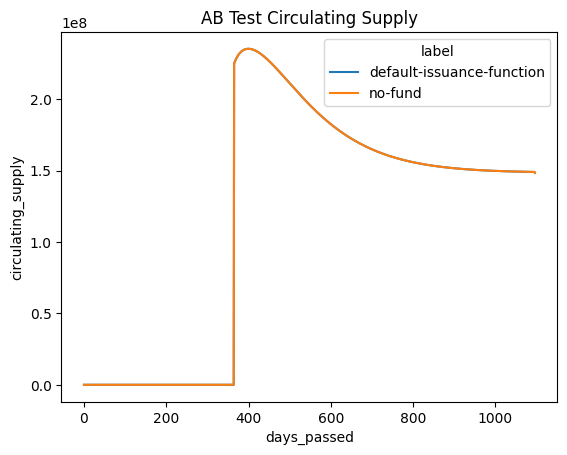

In [5]:
sns.lineplot(sim_df, x='days_passed', y='circulating_supply', hue='label').set(title='AB Test Circulating Supply')

[Text(0.5, 1.0, 'AB Test Operator Pool Shares')]

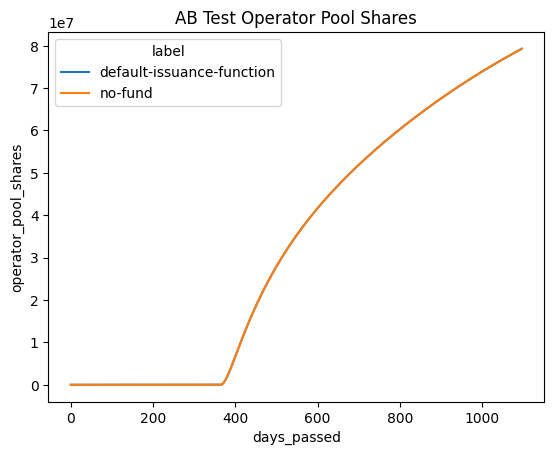

In [6]:
sns.lineplot(sim_df, x='days_passed', y='operator_pool_shares', hue='label').set(title='AB Test Operator Pool Shares')

[Text(0.5, 1.0, 'AB Test Nominator Pool Shares')]

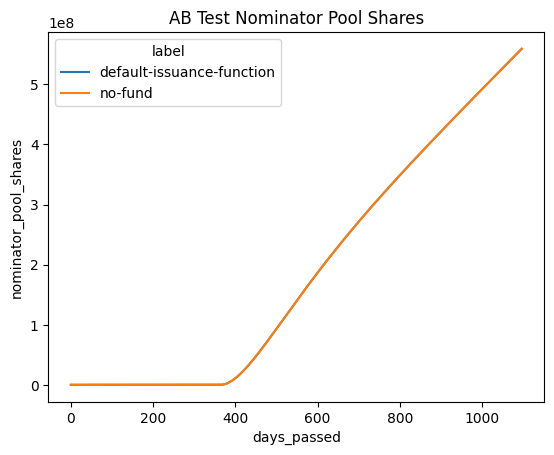

In [7]:
sns.lineplot(sim_df, x='days_passed', y='nominator_pool_shares', hue='label').set(title='AB Test Nominator Pool Shares')

[Text(0.5, 1.0, 'AB Test Block Utilization')]

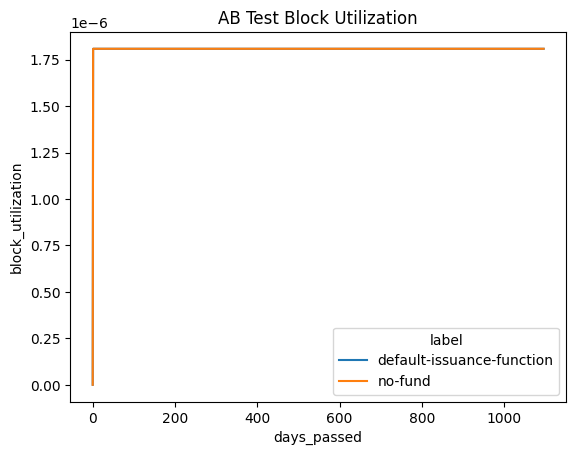

In [8]:
sns.lineplot(sim_df, x='days_passed', y='block_utilization', hue='label').set(title='AB Test Block Utilization')


2024-01-02 12:18:27 - subspace-digital-twin - INFO
------------subspace-digital-twin------------


[Text(0.5, 1.0, 'AB Test Windowed Volatility of Circulating Supply')]

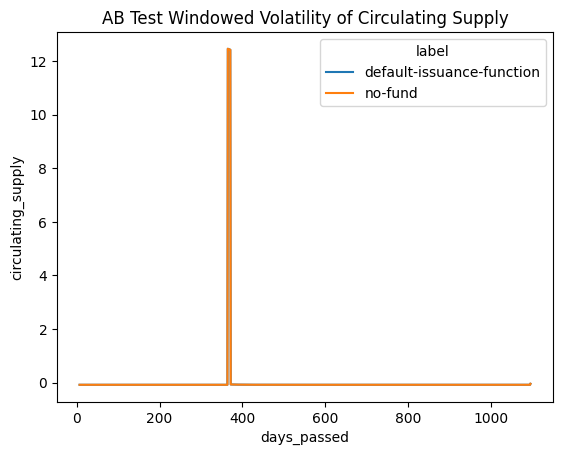

In [9]:
from subspace_model.experiments.metrics import *


lst = []
for i, g_df in sim_df.set_index(['label', 'run', 'days_passed']).groupby('run'):
    s = window_volatility(g_df.circulating_supply.diff()).reset_index()
    lst.append(s)

df = pd.concat(lst).dropna()
sns.lineplot(df, x='days_passed', y='circulating_supply', hue='label').set(title='AB Test Windowed Volatility of Circulating Supply')